# Package dependency
MDEncoder, numpy, pandas, hyperopt, MDAnalysis, hdbscan, matplotlib, seaborn

In [69]:
from MDEncoder import *
import numpy as np
import pandas as pd
from hyperopt import hp
import MDAnalysis as mda
from MDAnalysis.analysis import align
import seaborn as sns; sns.set(style="ticks",color_codes=True)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Conver MD trajectory to input data

In [145]:
# input trajectories: gpa-remd-window#
gpa_ref = mda.Universe('gpa/gpa-remd.psf', 'gpa/gpa-remd.pdb')
gpa = mda.Universe('gpa/gpa-remd.psf', 'gpa/gpa-remd-0.dcd','gpa/gpa-remd-1.dcd','gpa/gpa-remd-2.dcd','gpa/gpa-remd-3.dcd')
print(gpa)
print(len(gpa.trajectory))

<Universe with 428 atoms>
24292


In [146]:
#alignment with native structure, using helix A
aligner = align.AlignTraj(gpa, gpa_ref, select='backbone and segid AP1', in_memory=True).run()

In [147]:
#get xyz coordinate for input, and com/contact angle as CVs
position = []
com = []
cangle = []
for ts in gpa.trajectory:
    position.append(gpa.select_atoms('protein').positions.reshape(-1,))
    
    h1 = gpa.select_atoms('protein and name CA and segid AP1').center_of_mass()
    h2 = gpa.select_atoms('protein and name CA and segid BP1').center_of_mass()
    v1A = gpa.select_atoms('protein and backbone and segid AP1 and resid 79 83').center_of_mass()
    v1B = gpa.select_atoms('protein and backbone and segid BP1 and resid 79 83').center_of_mass()
    v2A = gpa.select_atoms('protein and backbone and segid AP1 and resid 81').center_of_mass()
    v2B = gpa.select_atoms('protein and backbone and segid BP1 and resid 81').center_of_mass()
    com.append(np.linalg.norm(h1-h2))    
    vA1 = v1A-v2A
    vAB1 = v1B-v1A
    angle1 = np.arccos(np.dot(vA1, vAB1)/(np.linalg.norm(vA1)*np.linalg.norm(vAB1)))/3.1415926*180
    vA2 = v1B-v2B
    vAB2 = v1A-v1B
    angle2 = np.arccos(np.dot(vA2, vAB2)/(np.linalg.norm(vA2)*np.linalg.norm(vAB2)))/3.1415926*180
    cangle.append( (angle1+angle2)/2 )
position = np.asarray(position)
com = np.asarray(com)
cangle = np.asarray(cangle)
print(position.shape,com.shape,cangle.shape)

(24292, 1284) (24292,) (24292,)


In [92]:
#get feature name for restructing pdb
feature_name = []
gpa_atoms = gpa.select_atoms('protein')
for res, seg, name, resn in zip(gpa_atoms.resids , gpa_atoms.segids, gpa_atoms.names, gpa_atoms.resnames):
    feature_name.append("{0}_{1}_{2}_{3}_x".format(seg,resn,res,name))
    feature_name.append("{0}_{1}_{2}_{3}_y".format(seg,resn,res,name))
    feature_name.append("{0}_{1}_{2}_{3}_z".format(seg,resn,res,name))
feature_name = np.asarray(feature_name)
print(feature_name.shape)

(1284,)


In [116]:
#save input files for future reference
np.savetxt("gpa/gpa-remd-position.txt",position,delimiter=" ")
np.savetxt("gpa/gpa-remd-com.txt",com,delimiter=" ")
np.savetxt("gpa/gpa-remd-cangle.txt",cangle,delimiter=" ")
np.savetxt("gpa/gpa-remd-feature_name.txt",feature_name,fmt='%.18s',delimiter=" ")

In [117]:
#read input data from files
position = np.loadtxt('gpa/gpa-remd-position.txt')
com = np.loadtxt('gpa/gpa-remd-com.txt')
cangle = np.loadtxt('gpa/gpa-remd-cangle.txt')
feature_name = np.loadtxt('gpa/gpa-remd-feature_name.txt',dtype='str')

# Data preprocessing

In [119]:
#filter for frames with cutoff of com<=12A 
cutoff12 = np.argwhere(com<=12).reshape((-1,)).tolist()
com_12A = com[cutoff12]
cangle_12A = cangle[cutoff12]

position_12A = position[cutoff12].copy()
data_processor_12 = preprocessing()
position_12A = data_processor_12.transform(position_12A)

Data dimension: (6072, 1284)


# Train a model

In [ ]:
# Optional: run a hyper parameter search using hyperopt package
# downsample the data set for a quick search
downsample = position_12A[::5,:]
space = {'n_neurons' : hp.choice('n_neurons',[64,128,256,512]), 'n_layers' : hp.choice('n_layers',[1,2,3,4]),
         'latent_dim' : hp.choice('latent_dim',[2]), 'sparse' : hp.choice('sparse',[0,1e-7,5e-7,1e-6]), 
         'alpha' : hp.uniform('alpha', 0.0, 1.0), 'lr' : hp.uniform('lr', 0.001, 0.02),
        'batch_size' : hp.choice('batch_size',[64,128,256,512]), 'f_dim' : hp.choice('f_dim',[data.shape[1]])}
search_model = hyperoptsearchCV(space,max_evals=30)
search_model.fit(downsample)
search_model.save("gpa/models/hyperoptsearch_REMD_12A.pkl")
print(search_model.best_param)

 97%|█████████▋| 29/30 [1:49:21<01:12, 72.11s/it, best loss: 0.15073073741750442]  

In [120]:
x_train, x_test, _, _ = train_test_split(position_12A,position_12A, test_size=0.1)

Layer dimensions:
Layer 0: 1284
Layer 1: 64
Layer 2: 2
Training RBM layer 1
Epoch  1
Reconstruction MSE =  0.17148573063758446
Epoch  2
Reconstruction MSE =  0.08118997756411786
Epoch  3
Reconstruction MSE =  0.07592413921685012
Epoch  4
Reconstruction MSE =  0.0710316464575607
Training RBM layer 2
Epoch  1
Reconstruction MSE =  0.2467954427231017
Epoch  2
Reconstruction MSE =  0.2430131417452269
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1284)         0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2)            82370       input_1[0][0]                    
_________________________________

Epoch 20/200
 - 0s - loss: 0.0013 - reconstruct_loss: 0.0019 - embedded_loss: 2.5123e-04 - reconstruct_RFVE_metric: 0.0234 - embedded_RV_metric: 0.1794 - val_loss: 0.0012 - val_reconstruct_loss: 0.0019 - val_embedded_loss: 2.6503e-04 - val_reconstruct_RFVE_metric: 0.0229 - val_embedded_RV_metric: 0.1846
Epoch 21/200
 - 0s - loss: 0.0012 - reconstruct_loss: 0.0019 - embedded_loss: 2.4655e-04 - reconstruct_RFVE_metric: 0.0226 - embedded_RV_metric: 0.1725 - val_loss: 0.0012 - val_reconstruct_loss: 0.0018 - val_embedded_loss: 2.5368e-04 - val_reconstruct_RFVE_metric: 0.0224 - val_embedded_RV_metric: 0.1636
Epoch 22/200
 - 0s - loss: 0.0012 - reconstruct_loss: 0.0018 - embedded_loss: 2.4047e-04 - reconstruct_RFVE_metric: 0.0222 - embedded_RV_metric: 0.1668 - val_loss: 0.0012 - val_reconstruct_loss: 0.0018 - val_embedded_loss: 2.5664e-04 - val_reconstruct_RFVE_metric: 0.0222 - val_embedded_RV_metric: 0.1566
Epoch 23/200
 - 0s - loss: 0.0012 - reconstruct_loss: 0.0018 - embedded_loss: 2.3753e

Epoch 47/200
 - 0s - loss: 9.1326e-04 - reconstruct_loss: 0.0014 - embedded_loss: 2.1375e-04 - reconstruct_RFVE_metric: 0.0170 - embedded_RV_metric: 0.1458 - val_loss: 9.1622e-04 - val_reconstruct_loss: 0.0014 - val_embedded_loss: 2.1168e-04 - val_reconstruct_RFVE_metric: 0.0171 - val_embedded_RV_metric: 0.1363
Epoch 48/200
 - 0s - loss: 9.2390e-04 - reconstruct_loss: 0.0014 - embedded_loss: 2.2229e-04 - reconstruct_RFVE_metric: 0.0172 - embedded_RV_metric: 0.1498 - val_loss: 9.2538e-04 - val_reconstruct_loss: 0.0014 - val_embedded_loss: 2.2305e-04 - val_reconstruct_RFVE_metric: 0.0172 - val_embedded_RV_metric: 0.1617
Epoch 49/200
 - 0s - loss: 9.0973e-04 - reconstruct_loss: 0.0014 - embedded_loss: 2.1576e-04 - reconstruct_RFVE_metric: 0.0169 - embedded_RV_metric: 0.1463 - val_loss: 9.1236e-04 - val_reconstruct_loss: 0.0014 - val_embedded_loss: 2.1059e-04 - val_reconstruct_RFVE_metric: 0.0171 - val_embedded_RV_metric: 0.1413
Epoch 50/200
 - 0s - loss: 9.0340e-04 - reconstruct_loss: 0.0

Epoch 74/200
 - 0s - loss: 8.4316e-04 - reconstruct_loss: 0.0013 - embedded_loss: 2.1105e-04 - reconstruct_RFVE_metric: 0.0158 - embedded_RV_metric: 0.1429 - val_loss: 8.5906e-04 - val_reconstruct_loss: 0.0013 - val_embedded_loss: 2.2160e-04 - val_reconstruct_RFVE_metric: 0.0160 - val_embedded_RV_metric: 0.1658
Epoch 75/200
 - 0s - loss: 8.4137e-04 - reconstruct_loss: 0.0013 - embedded_loss: 2.1132e-04 - reconstruct_RFVE_metric: 0.0157 - embedded_RV_metric: 0.1440 - val_loss: 8.5372e-04 - val_reconstruct_loss: 0.0013 - val_embedded_loss: 2.1076e-04 - val_reconstruct_RFVE_metric: 0.0160 - val_embedded_RV_metric: 0.1448
Epoch 76/200
 - 0s - loss: 8.3206e-04 - reconstruct_loss: 0.0013 - embedded_loss: 2.0798e-04 - reconstruct_RFVE_metric: 0.0155 - embedded_RV_metric: 0.1422 - val_loss: 8.3303e-04 - val_reconstruct_loss: 0.0013 - val_embedded_loss: 2.0582e-04 - val_reconstruct_RFVE_metric: 0.0156 - val_embedded_RV_metric: 0.1426
Epoch 77/200
 - 0s - loss: 8.2807e-04 - reconstruct_loss: 0.0

Epoch 101/200
 - 0s - loss: 7.8151e-04 - reconstruct_loss: 0.0012 - embedded_loss: 2.0823e-04 - reconstruct_RFVE_metric: 0.0144 - embedded_RV_metric: 0.1458 - val_loss: 8.0334e-04 - val_reconstruct_loss: 0.0012 - val_embedded_loss: 2.0712e-04 - val_reconstruct_RFVE_metric: 0.0149 - val_embedded_RV_metric: 0.1463
Epoch 102/200
 - 0s - loss: 7.8099e-04 - reconstruct_loss: 0.0012 - embedded_loss: 2.0801e-04 - reconstruct_RFVE_metric: 0.0144 - embedded_RV_metric: 0.1463 - val_loss: 7.9638e-04 - val_reconstruct_loss: 0.0012 - val_embedded_loss: 2.0905e-04 - val_reconstruct_RFVE_metric: 0.0148 - val_embedded_RV_metric: 0.1462
Epoch 103/200
 - 0s - loss: 7.7597e-04 - reconstruct_loss: 0.0012 - embedded_loss: 2.0730e-04 - reconstruct_RFVE_metric: 0.0143 - embedded_RV_metric: 0.1477 - val_loss: 8.0507e-04 - val_reconstruct_loss: 0.0012 - val_embedded_loss: 2.1051e-04 - val_reconstruct_RFVE_metric: 0.0150 - val_embedded_RV_metric: 0.1390
Epoch 104/200
 - 0s - loss: 7.7747e-04 - reconstruct_loss:

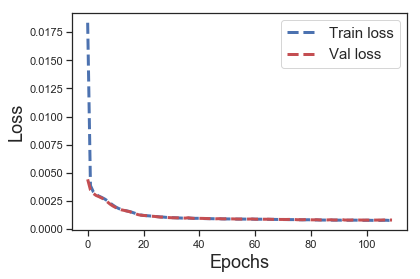

In [122]:
# Hyperparameters {'alpha': [0.45653097603416876], 'batch_size': 128, 'latent_dim': 2, 'lr': [0.017383238833972005], 'sparse': 1e-7}
model = MDEncoder(layer_dims=[position.shape[1],64,2], sparse = 1e-7, alpha = 0.457, lr = 0.00174 , batch_size = 128)
model.fit(x_train,x_test,output_path="gpa/models/gpa_remd_12A",verbose=2)

In [123]:
# project input data on lv space
lv = model.encoder.predict(position_12A)
cols = ['LV'+str(i) for i in range(1,model.layer_dims[-1]+1)]
lv_pd = pd.DataFrame(lv, columns=cols)

def lv_variance(pd):
    col = pd.columns
    sorted_idx = np.argsort(pd.var().to_numpy())[::-1]
    print(pd.var())
    print(col[sorted_idx])
    
lv_variance(lv_pd)

LV1    0.004736
LV2    0.003158
dtype: float32
Index(['LV1', 'LV2'], dtype='object')


In [124]:
# correlation b/w lv and CV
def CV_corr(pd,cv):
    cols = pd.columns
    result = np.empty((len(cols),))
    for i,col in enumerate(cols):
        result[i] = np.corrcoef(pd[col],cv)[0,1]
    sorted_idx = np.argsort(np.abs(result))[::-1]
    print(cols[sorted_idx])
    print(result[sorted_idx])
print("Correlation with COM distance:")
CV_corr(lv_pd,com_12A)
print("Correlation with cangle:")
CV_corr(lv_pd,cangle_12A)

Correlation with COM distance:
Index(['LV1', 'LV2'], dtype='object')
[ 0.49189518 -0.37551187]
Correlation with cangle:
Index(['LV1', 'LV2'], dtype='object')
[0.70466046 0.17602187]


# Model analysis

In [137]:
#clustering analysis in CV space, need to install hdbscan
def get_center(data,label):
    #helper functin for calculating center of cluster
    centers = []
    for i in np.unique(label):
        if i>=0:
            tmp = data[label==i,:]
            centers.append(np.mean(tmp,axis=0))
    return centers

import hdbscan

skip = 1
clusters = hdbscan.HDBSCAN(min_cluster_size=400,min_samples=80,alpha=1.0,core_dist_n_jobs=-1,
                           cluster_selection_epsilon=0.012,cluster_selection_method='leaf').fit(lv[::skip,:])

#label_lv = -1 indicate noise
label_lv = clusters.labels_
centers_lv = get_center(lv[::skip,:],label_lv)
num_clusters = len(set(label_lv)) - (1 if -1 in label_lv else 0)
l , l_count = np.unique(label_lv, return_counts=True)
print("Number of clusters: {0}, members counts: {1}".format(num_clusters,l_count[1:]))

Number of clusters: 4, members counts: [ 429  563 1226 3773]


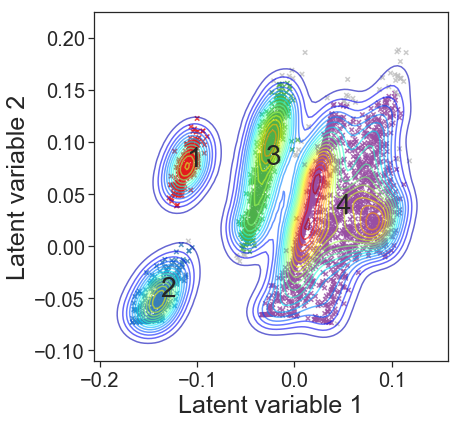

In [138]:
#scatter plot in LV space, colored by clusters
import matplotlib as mpl
fs = 25
skip = 2

xdata , ydata =  lv_pd['LV1'], lv_pd['LV2']
xlim=(xdata.min()-0.05,xdata.max()+0.05)
ylim=(ydata.min()-0.05,ydata.max()+0.05)

fig = plt.figure(figsize=(6.5,6))

sns.kdeplot(xdata.iloc[::skip],ydata.iloc[::skip], cmap='jet',alpha=0.6,n_levels=20)

color_palette = sns.color_palette('Set1',16)
label_c = [color_palette[x] if x>=0 else (0.75,0.75,0.75) for x in label_lv]
plt.scatter(xdata[::skip],ydata[::skip],c=label_c[::skip], marker='x',s=20,alpha=0.8)
        
for n, center in enumerate(centers_lv):
    plt.text(center[0],center[1], str(n+1) ,fontsize=28) 

plt.xlabel('Latent variable 1',fontsize=fs)
plt.ylabel('Latent variable 2',fontsize=fs)

plt.xticks(fontsize=fs-5)
plt.yticks(fontsize=fs-5)
fig.tight_layout()
#fig.savefig('figs/GpA-US-LV-3clusters.png',dpi=200)

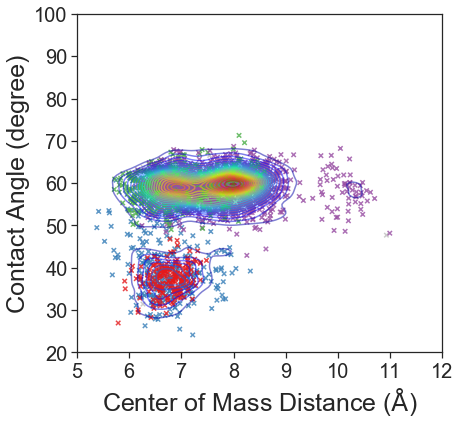

In [139]:
#scatter plot in CV space, colored by clusters
color_palette = sns.color_palette('Set1',16)
label_c = np.array([color_palette[x] if x>=0 else (0.75,0.75,0.75) for x in label_lv])
skip = 2
fs = 25

fig = plt.figure(figsize=(6.5,6))
xdata , ydata = com_12A , cangle_12A
    
sns.kdeplot(xdata[::skip*2],ydata[::skip*2], cmap='jet',alpha=0.5,n_levels=25)
plt.scatter(xdata[::skip],ydata[::skip],c=label_c[::skip] , marker='x',s=20,alpha=0.8)
    
plt.xlim((5,12))
plt.ylim((20,100))
plt.xlabel(r'Center of Mass Distance (${\rm \AA}$)',fontsize=fs)
plt.ylabel(r'Contact Angle (degree)',fontsize=fs)
plt.xticks(np.arange(5,13,step=1),fontsize=fs-5)
plt.yticks(np.arange(20,102,step=10),fontsize=fs-5)

plt.rc('xtick',labelsize=fs-5)
plt.rc('ytick',labelsize=fs-5)
fig.tight_layout()
#fig.savefig('figs/GpA-US-com-cangle-rmsdclusters.png',dpi=200)

# Reconstructing pdb for visualization of clustering analysis

In [144]:
#generate pdb structures for cluster centers, using helper function from MDEncoder package
reconst = model.decoder.predict(np.asarray(centers_lv))
reconst = data_processor_12.inverse_transform(reconst)
generate_pdb(reconst,'gpa/samples/test.pdb',feature_name)

Generated pdb to gpa/samples/test.pdb !
